In [1]:
# Few import statements
import os
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import TimeDistributed, Dense
from keras.layers.recurrent import LSTM
from IPython.display import Audio
from pipes import quote

import keras
print(keras.__version__)

Using TensorFlow backend.


2.0.2


In [2]:
def read_wav_as_np(file):
    # wav.read returns the sampling rate per second  (as an int) and the data (as a numpy array)
    data = wav.read(file)
    # Normalize 16-bit input to [-1, 1] range
    np_arr = data[1].astype('float32') / 32767.0
    #np_arr = np.array(np_arr)
    return np_arr, data[0]

In [3]:
def write_np_as_wav(X, sample_rate, file):
    # Converting the tensor back to it's original form
    Xnew = X * 32767.0
    Xnew = Xnew.astype('int16')
    # wav.write constructs the .wav file using the specified sample_rate and tensor
    wav.write(file, sample_rate, Xnew)
    return

In [4]:
def convert_sample_blocks_to_np_audio(blocks):
    # Flattens the blocks into a single list
    song_np = np.concatenate(blocks)
    return song_np

In [5]:
def convert_np_audio_to_sample_blocks(song_np, block_size):

    # Block lists initialised
    block_lists = []

    # total_samples holds the size of the numpy array
    total_samples = song_np.shape[0]
    # print('total_samples=',total_samples)

    # num_samples_so_far is used to loop through the numpy array
    num_samples_so_far = 0

    while (num_samples_so_far < total_samples):

        # Stores each block in the "block" variable
        block = song_np[num_samples_so_far:num_samples_so_far + block_size]

        if (block.shape[0] < block_size):
            # this is to add 0's in the last block if it not completely filled
            padding = np.zeros((block_size - block.shape[0],))
            # block_size is 44100 which is fixed throughout whereas block.shape[0] for the last block is <=44100
            block = np.concatenate((block,padding))
        block_lists.append(block)
        num_samples_so_far += block_size
    return block_lists

In [6]:
def time_blocks_to_fft_blocks(blocks_time_domain):
    # FFT blocks initialized
    fft_blocks = []
    for block in blocks_time_domain:
        # Computes the one-dimensional discrete Fourier Transform and returns the complex nD array
        # i.e The truncated or zero-padded input, transformed from time domain to frequency domain.
        fft_block = np.fft.fft(block)
        # Joins a sequence of blocks along frequency axis.
        new_block = np.concatenate((np.real(fft_block), np.imag(fft_block)))
        fft_blocks.append(new_block)
    return fft_blocks

In [7]:
def fft_blocks_to_time_blocks(blocks_ft_domain):
    # Time blocks initialized
    time_blocks = []
    for block in blocks_ft_domain:
        num_elems = block.shape[0] / 2
        # Extracts real part of the amplitude corresponding to the frequency
        real_chunk = block[0:num_elems]
        # Extracts imaginary part of the amplitude corresponding to the frequency
        imag_chunk = block[num_elems:]
        # Represents amplitude as a complex number corresponding to the frequency
        new_block = real_chunk + 1.0j * imag_chunk
        # Computes the one-dimensional discrete inverse Fourier Transform and returns the transformed
        # block from frequency domain to time domain
        time_block = np.fft.ifft(new_block)
        # Joins a sequence of blocks along time axis.
        time_blocks.append(time_block)
    return time_blocks

In [8]:
sample_frequency = 44100
block_size = 44100
#filename = 'Test.mp3'

In [9]:

filename_tmp = 'new_'+filename[:-4] + '_Mono.mp3'
new_name = 'new_'+filename[:-4] + '.wav'

# These lines calls LAME to resample the audio file at the standard analog frequency of 44,100 Hz and then convert it to WAV
sample_freq_str = "{0:.1f}".format(float(sample_frequency) / 1000.0)
cmd = 'lame -a -m m {0} {1}'.format(quote(filename), quote(filename_tmp))
os.system(cmd)
cmd = 'lame --decode {0} {1} --resample {2}'.format(quote(filename_tmp), quote(new_name), sample_freq_str)
os.system(cmd)

0

In [14]:
new_name = 'YourMusicLibraryNP_xmerged.wav'

bitrate, data = wav.read(new_name)


# wav_array contains normalized data
wav_array, bitrate = read_wav_as_np(new_name)
# wav_array is converted into blocks with zeroes padded to fill the empty space in last block if any
wav_blocks_zero_padded = convert_np_audio_to_sample_blocks(wav_array, block_size)


# Flattens the blocks into an array
wav_array_zero_padded = convert_sample_blocks_to_np_audio(wav_blocks_zero_padded)


shifted_wav_blocks_zero_padded = wav_blocks_zero_padded[1:]
shifted_wav_array_zero_padded = convert_sample_blocks_to_np_audio(shifted_wav_blocks_zero_padded)


# Fast fourier transforming the wav blocks into frequency domain
print('Dimension of wav blocks before fft: ',np.shape(wav_blocks_zero_padded))

X = time_blocks_to_fft_blocks(wav_blocks_zero_padded)
Y = time_blocks_to_fft_blocks(shifted_wav_blocks_zero_padded)



('Dimension of wav blocks before fft: ', (130, 44100))


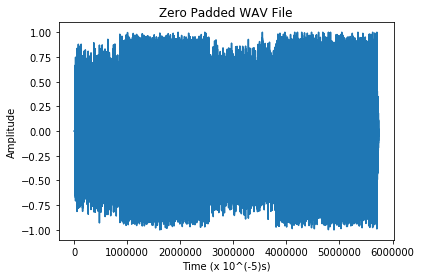

In [15]:
#np.save('Test.npy',(x_data,y_data))
hey1 = wav_array_zero_padded
plt.plot(wav_array_zero_padded)
plt.title("Zero Padded WAV File")
plt.xlabel("Time (x 10^(-5)s)")
plt.ylabel("Amplitude")
plt.show()

In [16]:
new_name = 'generated_music.wav'

bitrate, data = wav.read(new_name)


# wav_array contains normalized data
wav_array, bitrate = read_wav_as_np(new_name)
# wav_array is converted into blocks with zeroes padded to fill the empty space in last block if any
wav_blocks_zero_padded = convert_np_audio_to_sample_blocks(wav_array, block_size)


# Flattens the blocks into an array
wav_array_zero_padded = convert_sample_blocks_to_np_audio(wav_blocks_zero_padded)


shifted_wav_blocks_zero_padded = wav_blocks_zero_padded[1:]
shifted_wav_array_zero_padded = convert_sample_blocks_to_np_audio(shifted_wav_blocks_zero_padded)


# Fast fourier transforming the wav blocks into frequency domain
print('Dimension of wav blocks before fft: ',np.shape(wav_blocks_zero_padded))

X = time_blocks_to_fft_blocks(wav_blocks_zero_padded)
Y = time_blocks_to_fft_blocks(shifted_wav_blocks_zero_padded)


('Dimension of wav blocks before fft: ', (109, 44100))


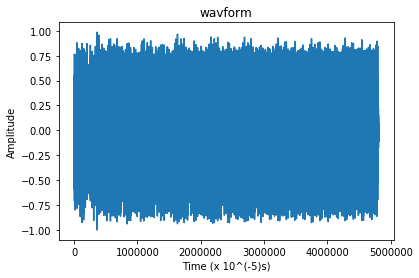

In [23]:
plt.plot(wav_array_zero_padded)
plt.title("wavform")
plt.xlabel("Time (x 10^(-5)s)")
plt.ylabel("Amplitude")
plt.show()

In [25]:
yah = np.array([wav_array_zero_padded[i] - hey1[i] for i in xrange(100000) if wav_array_zero_padded[i] > 0 else -1.0])
plt.plot(yah)
plt.title("wavform")
plt.xlabel("Time (x 10^(-5)s)")
plt.ylabel("Amplitude")
plt.show()

SyntaxError: invalid syntax (<ipython-input-25-1513edc2933a>, line 1)

In [14]:
del x_data,y_data

In [15]:
x_data, y_data = np.load('Test.npy')

In [24]:
np.random.randint(low = 0,high = 10)

7

In [2]:
Audio('generated_music.wav')